# Transit light curve fitting

In this notebook, we will use `jaxoplanet` to fit a transit light curve. As this is a `jax`-based code, we will subsequently use `numpyro` to sample the posterior distribution. Let's start:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
from jaxoplanet.light_curves import limb_dark_light_curve
from jaxoplanet.orbits import TransitOrbit
import arviz as az
import corner
import os
import pickle

/Users/japa6985/opt/anaconda3/envs/exo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's now load and plot the data:

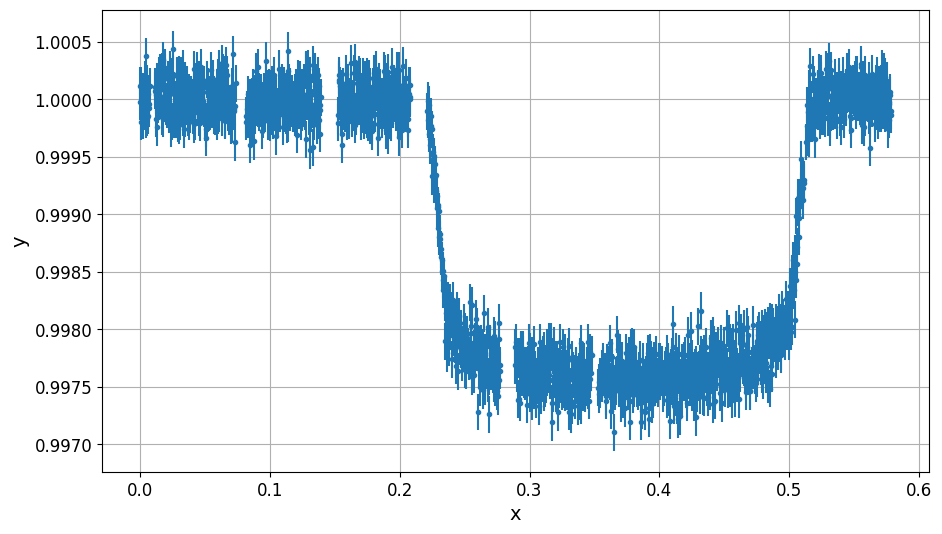

In [2]:
# But first, Set the number of cores on your machine for parallelism:
pout = os.getcwd() + '/Analysis/NumPyro_Synth'
cpu_cores = 2
numpyro.set_host_device_count(cpu_cores)

# Visualising the data
tim_full, fl, fle = np.loadtxt(os.getcwd() + '/kelt-11-synthetic.dat', usecols=(0,1,2), unpack=True)
tim = tim_full - tim_full[0]

fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(tim, fl, yerr=fle, fmt='.')
axs.set_xlabel('x', fontsize=14)
axs.set_ylabel('y', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.grid()
plt.show()

Some planetary parameters for priors:

In [3]:
per, per_err = 4.7360990, np.sqrt((0.0000290**2) + (0.0000270**2))
tc1, tc1_err = 2458553.81381, 0.00033
cycle = round((tim_full[0] - tc1)/per)
ar, ar_err = 4.98, 0.05
bb, bb_err = 0.404, np.sqrt((0.013**2) + (0.018**2))
rprs, rprs_err = 0.0475, 0.0006

t14 = 0.2954
t00 = tc1 + (cycle * per) - tim_full[0]

Setting up the model and MCMC:

In [4]:
# And modelling it
## First defining a numpyro model
def model():
    # Priors on the model parameters
    tc = numpyro.sample('tc', dist.Uniform(low=0.2, high=0.5))
    dur = numpyro.sample('duration', dist.Uniform(low=0.1, high=0.5))
    bb = numpyro.sample('bb', dist.Uniform(low=0., high=1.))
    rprs = numpyro.sample('rprs', dist.Uniform(low=0., high=1.))
    u1 = numpyro.sample('u1', dist.Uniform(low=0., high=1.))
    u2 = numpyro.sample('u2', dist.Uniform(low=0., high=1.))
    sig_w = numpyro.sample('sig_w', dist.LogUniform(low=0.1, high=1e4))
    # Let's also track the value of line for each iteration
    # The orbit and light curve
    orbit = TransitOrbit(period=per, duration=dur, time_transit=tc, impact_param=bb, radius_ratio=rprs)
    y_pred = limb_dark_light_curve(orbit, [u1, u2])(tim) + 1.
    numpyro.deterministic('y', y_pred)
    # And the likelihood function,
    numpyro.sample('obs', dist.Normal(loc=y_pred, scale=jnp.sqrt( jnp.power(fle, 2) + jnp.power(sig_w*1e-6, 2) ) ), obs=fl)

## -------   And sampling
# Random numbers in jax are generated like this:
rng_seed = 42
rng_keys = split(PRNGKey(rng_seed), cpu_cores)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(model, dense_mass=True)

# Monte Carlo sampling for a number of steps and parallel chains:
mcmc = MCMC(sampler, num_warmup=10_000, num_samples=10_000, num_chains=cpu_cores)

And, running the MCMC:

In [5]:
# Run the MCMC
mcmc.run(rng_keys)

Compiling.. :   0%|          | 0/20000 [00:00<?, ?it/s]

In [6]:
# Using arviz to extract results
# arviz converts a numpyro MCMC object to an `InferenceData` object based on xarray:
result = az.from_numpyro(mcmc)
pickle.dump(result, open(pout + '/res_numpyro.pkl','wb'))

# Result summary
summary = az.summary(result, var_names=['tc', 'duration', 'bb', 'rprs', 'u1', 'u2', 'sig_w'])
print(summary)

Running chain 0: 100%|██████████| 20000/20000 [05:15<00:00, 63.40it/s]


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
tc        0.369  0.000   0.368    0.369      0.000    0.000   11669.0   
duration  0.297  0.001   0.296    0.299      0.000    0.000    6560.0   
bb        0.470  0.042   0.394    0.547      0.001    0.000    6220.0   
rprs      0.048  0.000   0.047    0.048      0.000    0.000    4673.0   
u1        0.071  0.045   0.000    0.149      0.001    0.001    2065.0   
u2        0.346  0.070   0.207    0.463      0.001    0.001    2338.0   
sig_w     3.917  5.787   0.100   15.428      0.058    0.076    7689.0   

          ess_tail  r_hat  
tc         10022.0    1.0  
duration    7737.0    1.0  
bb          6636.0    1.0  
rprs        4140.0    1.0  
u1          1922.0    1.0  
u2          1706.0    1.0  
sig_w       8700.0    1.0  


Some plotting now:

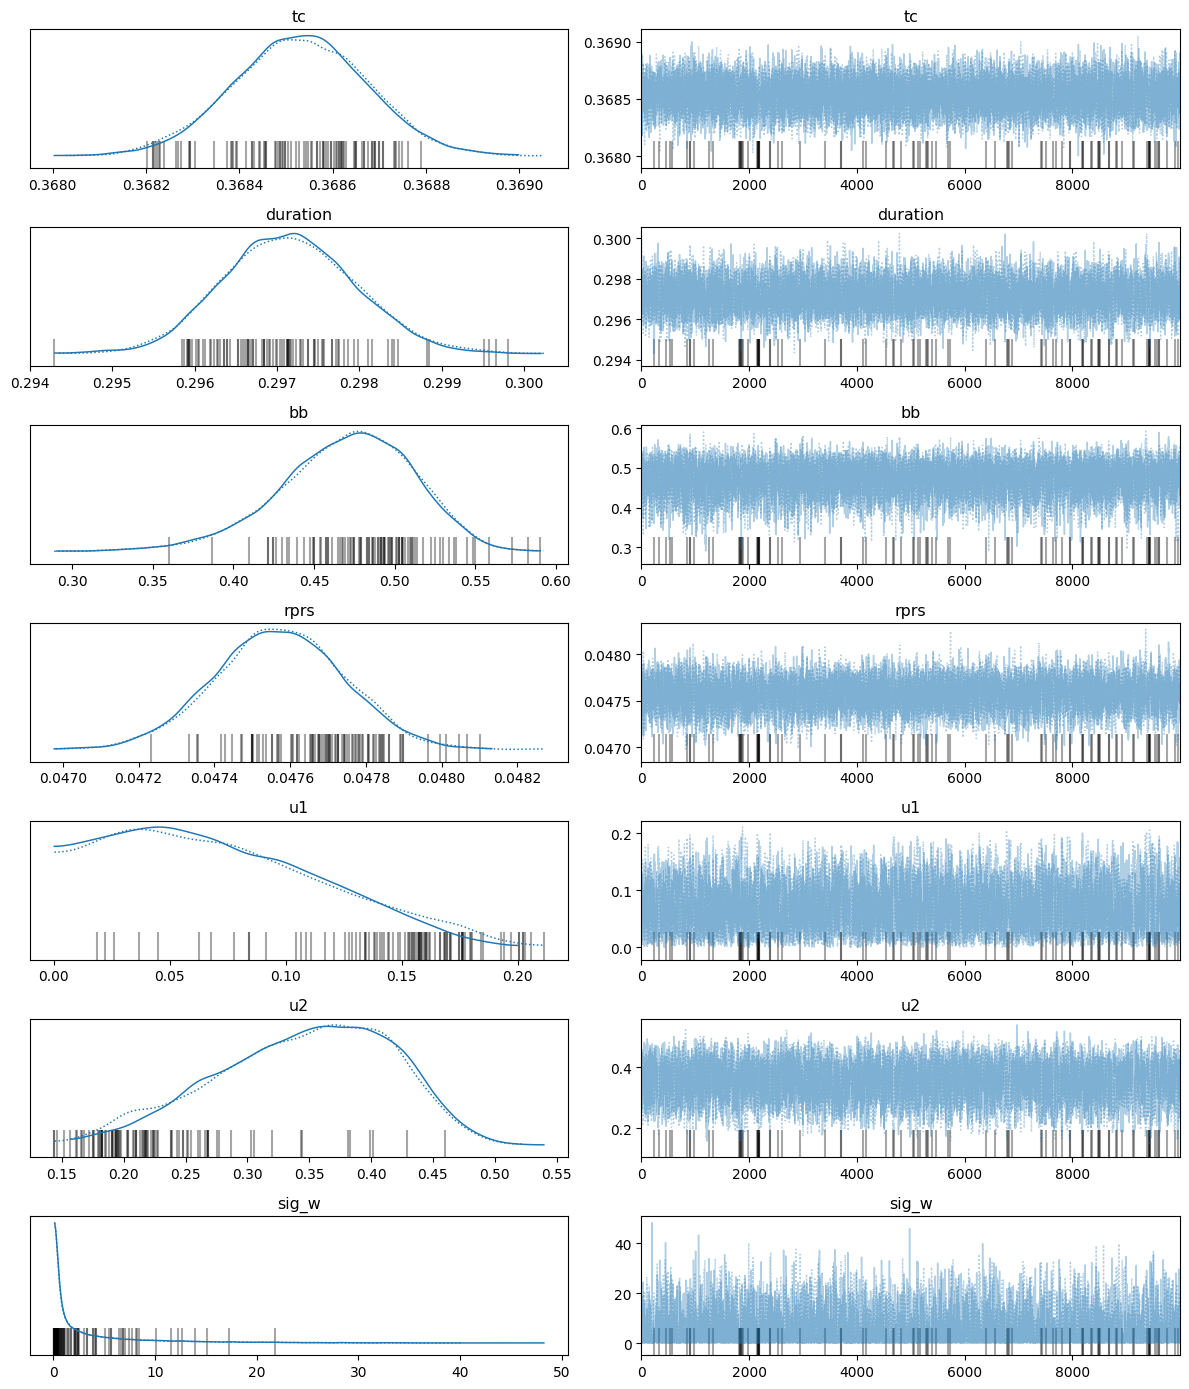

In [7]:
# Trace plots
_ = az.plot_trace(result, var_names=['tc', 'duration', 'bb', 'rprs', 'u1', 'u2', 'sig_w'])
plt.tight_layout()
#plt.show()
plt.savefig(pout + '/trace.png', dpi=500)

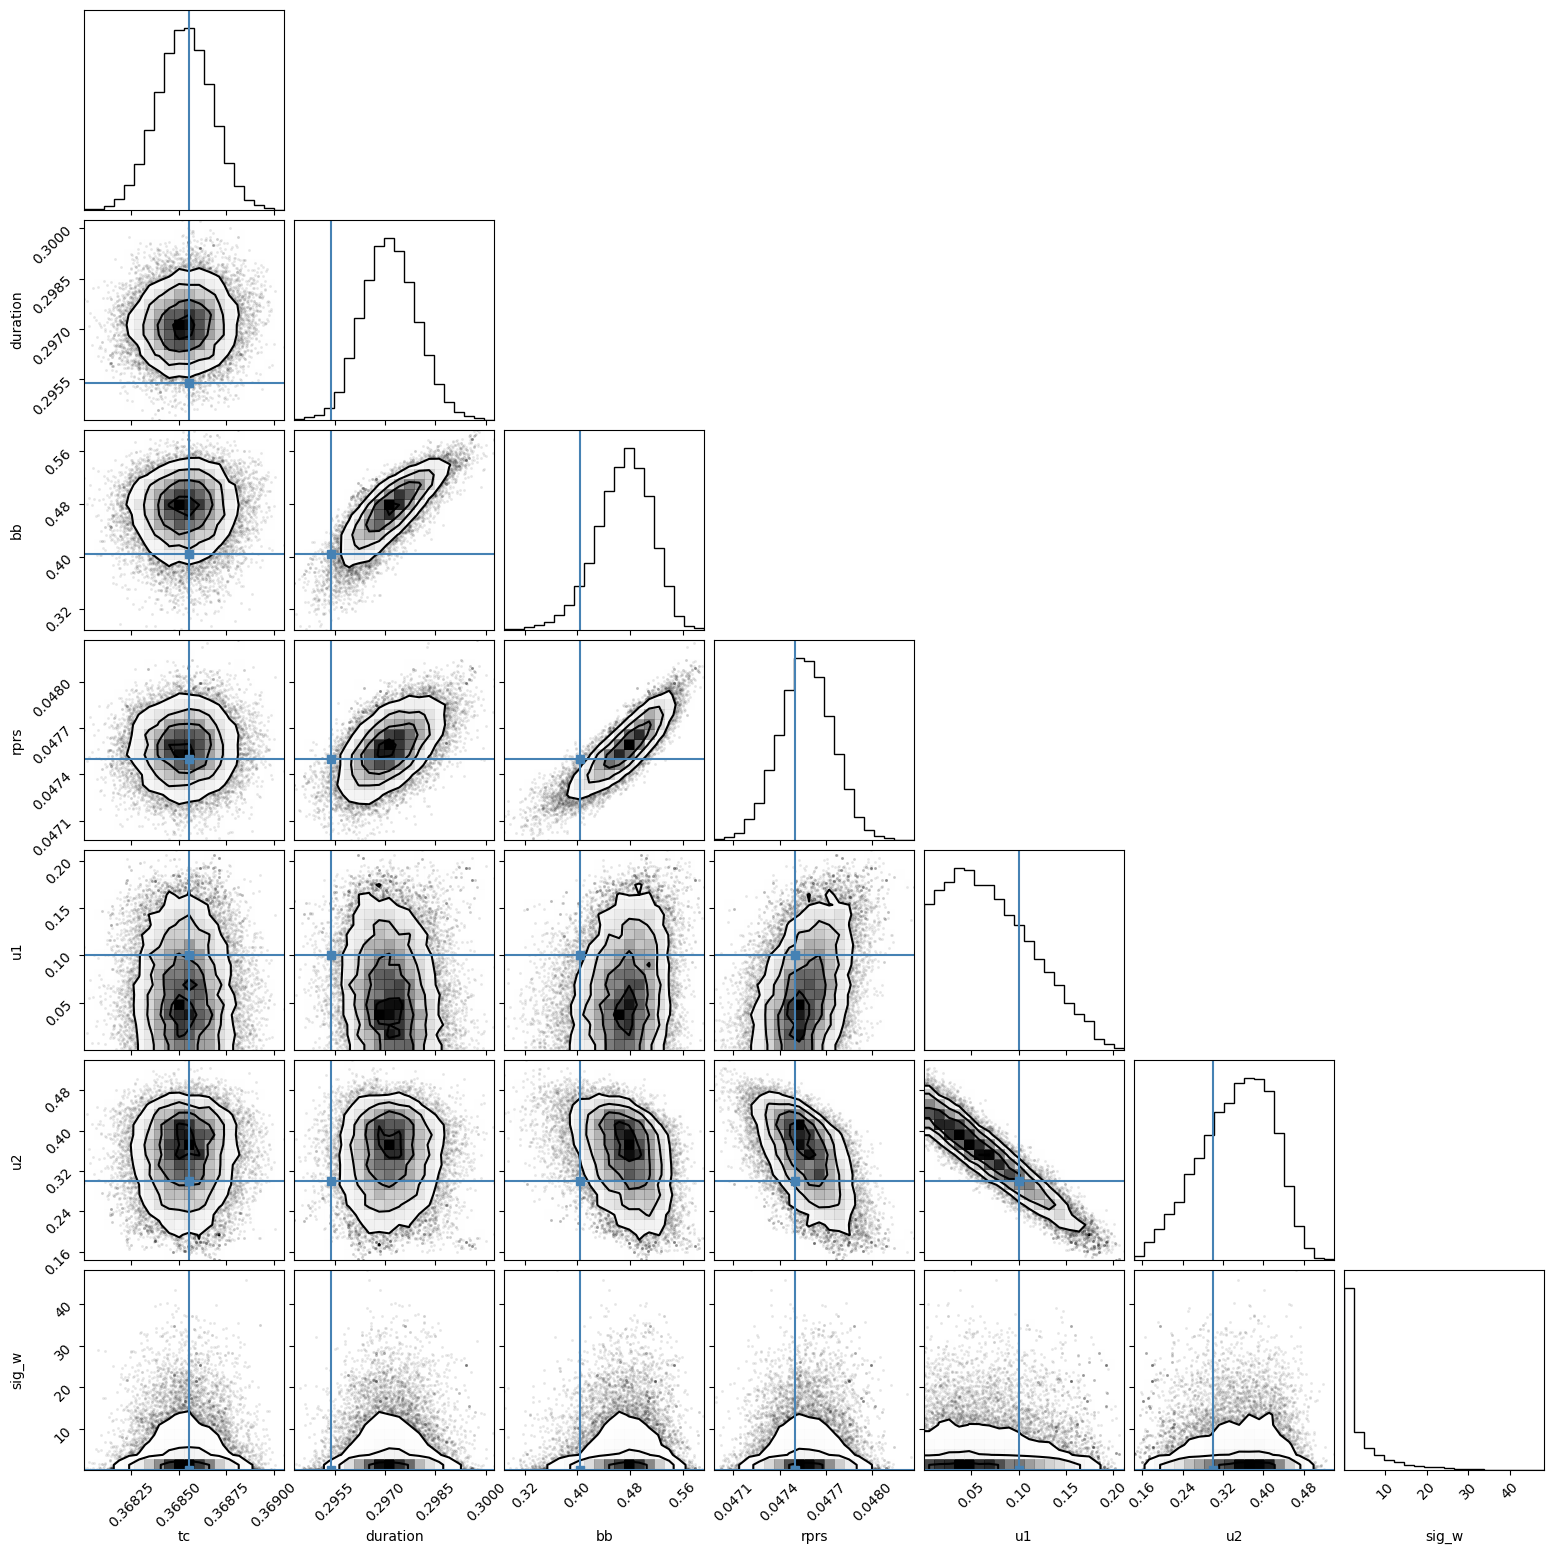

In [8]:
# Corner plot
truth = dict(zip(['tc', 'duration', 'bb', 'rprs', 'u1', 'u2', 'sig_w'],\
        np.array([t00, t14, bb, rprs, 0.1, 0.3, 0.]),))
_ = corner.corner(result, var_names=['tc', 'duration', 'bb', 'rprs', 'u1', 'u2', 'sig_w'], truths=truth,);
#plt.show()
plt.savefig(pout + '/corner.png', dpi=500)

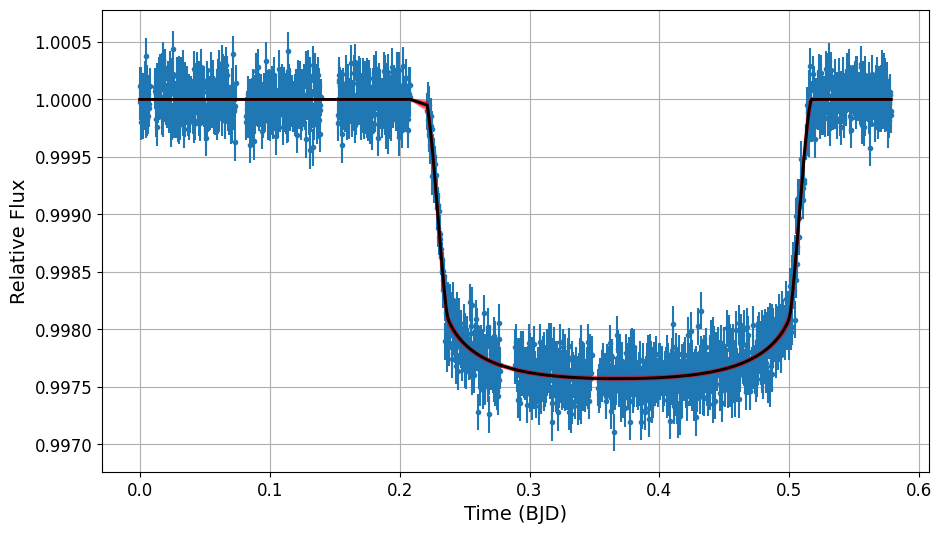

In [9]:
# Defining posteriors for each variable
y1 = np.array(result.posterior['y']).reshape(20000, len(tim))

# Plotting the results
fig, axs = plt.subplots(figsize=(16/1.5, 9/1.5))
axs.errorbar(tim, fl, yerr=fle, fmt='.')
axs.plot(tim, np.nanmedian(y1, axis=0), 'k-', lw=2., zorder=10)
for i in range(50):
    axs.plot(tim, y1[np.random.choice(np.arange(6000), replace=False),:], 'r-', alpha=0.1, zorder=7)
axs.set_xlabel('Time (BJD)', fontsize=14)
axs.set_ylabel('Relative Flux', fontsize=14)
plt.setp(axs.get_xticklabels(), fontsize=12)
plt.setp(axs.get_yticklabels(), fontsize=12)
plt.grid()
#plt.show()
plt.savefig(pout + '/model.png', dpi=500)